In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

In [420]:
class Emprunteur_agent():

    def __init__(self, taux, montant_restant, duree_restante, proba_default, date_emprunt, notation=None, a_fait_defaut=False):
        self.id = np.random.randint(0, 10000000)
        self.taux = taux
        self.montant_initial = montant_restant # montant initial emprunté
        self.montant_restant = montant_restant # montant restant dû
        self.mensualite = montant_restant * (taux / 12) / (1 - (1 + taux / 12) ** -duree_restante)
        self.duree_restante = duree_restante # durée restante
        self.duree_totale = duree_restante # durée totale
    
        self.proba_default = proba_default # probabilité de défaut
        self.date_emprunt = date_emprunt # date de l'emprunt (pour calculer la durée restante)

        self.a_fait_defaut = a_fait_defaut

        self.notation = notation # notation de l'emprunteur

    def __str__(self):
        if self.a_fait_defaut != True:
            return f"Emprunteur N°{self.id} a {self.montant_restant}€ restant à rembourser, avec une mensualité de {self.mensualite:.2f}€ et un taux de {self.taux * 100}%, (risque de défaut de {self.proba_default * 100}%)"
        else:
            return f"L'emprunteur N°{self.id} a fait défaut (montant restant : {self.montant_initial}€)"
    
    def remboursement_mensuel(self):
        self.montant_restant -= self.mensualite
        self.duree_restante -= 1

    def taux_effectif(self):
        s = 0
        for _ in range(self.duree_totale):
            s += self.mensualite
        return (s - self.montant_initial) / (self.montant_initial * self.duree_totale)


class Portfolio():
    def __init__(self, liste_emprunteurs, liquidite):
        self.liste_emprunteurs = liste_emprunteurs
        self.liquidite = -liquidite
        self.amortissements = {}
        for e in self.liste_emprunteurs:
            self.liquidite -= e.montant_initial
    
    def mensualite_totale(self):
        cumul = 0
        for emprunteur in self.liste_emprunteurs:
            cumul += emprunteur.mensualite
        return cumul
    
    def montant_initial(self):
        cumul = 0
        for emprunteur in self.liste_emprunteurs:
            cumul += emprunteur.montant_initial
        return cumul

    def montant_total(self):
        cumul = 0
        for emprunteur in self.liste_emprunteurs:
            cumul += emprunteur.montant_restant
        return cumul
    
    def montant_remboursement_total(self, emprunteur):
        cumul = 0
        for _ in range(emprunteur.duree_restante):
            cumul += emprunteur.mensualite
            emprunteur.remboursement_mensuel()
        return cumul   
    
    def default(self, e):
        if np.random.rand() < e.proba_default:
            e.a_fait_defaut = True
            e.montant_restant = 0
            e.duree_restante = 0

    def amortissement_emprunteur_new(self, e):
        cumul = 0
        for _ in range(e.duree_restante):
            cumul += e.mensualite
            self.default(e)
            if e.a_fait_defaut:
                break
            else:
                self.liquidite += e.mensualite
                e.remboursement_mensuel()
        self.amortissements[e.id] = cumul
        return cumul

class Strategy():

    def __init__(self, nb_emprunt, montant_a_investir, date_emprunt, taux, proba_defaut):
        self.nb_emprunt = nb_emprunt # nombre d'emprunts à investir 
        self.montant_a_investir = montant_a_investir # montant à investir
        self.date_emprunt = date_emprunt # date de l'emprunt
        self.amortissements = {} # dictionnaire des amortissements des emprunteurs
        self.portfolio = None # portefeuille d'emprunteurs 
        self.taux = taux # taux d'intérêt moyen
        self.proba_defaut = proba_defaut # probabilité de défaut moyenne

    def investissement(self):
        montant_par_emprunt = self.montant_a_investir / self.nb_emprunt
        liste_emprunteurs = []
        for _ in range(self.nb_emprunt):
            taux = round(np.random.uniform(self.taux * 0.9,self.taux * 1.1), 2)
            montant_restant = np.random.randint(montant_par_emprunt, montant_par_emprunt+1)
            duree_restante = np.random.randint(12, 36)
            defaut = round(np.random.uniform(self.proba_defaut * 0.9, 1.1 * self.proba_defaut), 2) / duree_restante
            liste_emprunteurs.append(Emprunteur_agent(taux, montant_restant, duree_restante, defaut, self.date_emprunt))
            self.montant_a_investir -= montant_restant
        self.portfolio = Portfolio(liste_emprunteurs, self.montant_a_investir)        

    def Liquidite(self):
        for e in self.portfolio.liste_emprunteurs:
            self.amortissements[e.id] = self.portfolio.amortissement_emprunteur_new(e)
        return self.portfolio.liquidite
    


class Backtest:

    def __init__(self, nb_emprunt, montant_a_investir, date_emprunt, taux, proba_defaut, nb_essais):
        self.nb_emprunt = nb_emprunt
        self.montant_a_investir = montant_a_investir
        self.date_emprunt = date_emprunt
        self.taux = taux
        self.proba_defaut = proba_defaut
        self.nb_essais = nb_essais

        self.final_liquidite = None
        self.results = None
        self.is_backtested = False
        self.is_results_calculated = False


    def backtest(self):
        self.results = {}

        final_liquidite = {}
        for n in tqdm(self.nb_emprunt):
            self.results[n] = {}
            final_liquidite[n] = []
            for _ in range(self.nb_essais):
                s = Strategy(n, self.montant_a_investir, self.date_emprunt, self.taux, self.proba_defaut)
                s.investissement()
                final_liquidite[n].append(s.Liquidite())

        self.final_liquidite = pd.DataFrame(final_liquidite, columns=self.nb_emprunt, index=range(self.nb_essais))
        self.is_backtested = True

    def calculate_results(self):
        if not self.is_results_calculated:
            for n in self.nb_emprunt:
                self.results[n]['VaR 95%'] = self.final_liquidite[n].quantile(0.05)
                self.results[n]['ES 95%'] = self.final_liquidite[n][self.final_liquidite[n] < self.results[n]['VaR 95%']].mean()
                self.results[n]['VaR 99%'] = self.final_liquidite[n].quantile(0.01)
                self.results[n]['ES 99%'] = self.final_liquidite[n][self.final_liquidite[n] < self.results[n]['VaR 99%']].mean()
                self.results[n]['Mean'] = self.final_liquidite[n].mean()
                self.results[n]['Std'] = self.final_liquidite[n].std()
                self.results[n]['Max'] = self.final_liquidite[n].max()
                self.results[n]['Min'] = self.final_liquidite[n].min()
                self.results[n]['Median'] = self.final_liquidite[n].median()
                self.results[n]['Mode'] = self.final_liquidite[n].mode()

                self.results[n]['Expected Loss'] = self.final_liquidite[n][self.final_liquidite[n] < 0].mean()
                self.results[n]['Expected Gain'] = self.final_liquidite[n][self.final_liquidite[n] > 0].mean()
                self.results[n]['Lower Semi Deviation'] = self.final_liquidite[n][self.final_liquidite[n] < self.results[n]['Mean']].std()
                self.results[n]['Upper Semi Deviation'] = self.final_liquidite[n][self.final_liquidite[n] > self.results[n]['Mean']].std()

                self.results[n]['Sortino Ratio'] = self.results[n]['Mean'] / self.results[n]['Lower Semi Deviation']
                self.results[n]['Sharpe Ratio'] = self.results[n]['Mean'] / self.results[n]['Std']
                self.results[n]['Information Ratio'] = self.results[n]['Mean'] / self.results[n]['ES 95%']
                self.results[n]['Calmar Ratio'] = self.results[n]['Mean'] / self.final_liquidite[n].max()
                self.results[n]['Sterling Ratio'] = self.results[n]['Mean'] / self.results[n]['Lower Semi Deviation']
                self.results[n]['Skewness'] = self.final_liquidite[n].skew()
                self.results[n]['Kurtosis'] = self.final_liquidite[n].kurtosis()

                self.results[n] = pd.DataFrame(self.results[n], index=[n])
            # Combine all results into a single DataFrame
            self.results = pd.concat(self.results, axis=0).reset_index(drop=True).T
            self.results = self.results.round(3)
            self.results.columns = self.nb_emprunt
            self.is_results_calculated = True
        else:
            print("Results already calculated")


    def plot_results(self):
        for n in self.nb_emprunt:
            plt.figure(figsize=(15, 5))
            sns.histplot(self.final_liquidite[n], kde=True, label=f"{n} emprunts", color=[np.random.rand(), np.random.rand(), np.random.rand()])
            plt.title("Distribution du gain final")
            plt.xlabel("Gain/Perte (€)")
            plt.ylabel("Nb d'occurences")
            plt.legend()
            plt.show()

In [334]:
# from mpl_toolkits.mplot3d import Axes3D
# import numpy as np
# import matplotlib.pyplot as plt

# m = range(6, 48)
# r = np.linspace(0.01, 0.11, 50)

# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')

# X, Y = np.meshgrid(m, r)
# Z = np.array([[Emprunteur_agent(j, 1000, i, 0.1, "2021-01-01").taux_effectif() for i in m] for j in r])  # Convert to NumPy array

# ax.plot_surface(X, Y, Z, cmap='viridis', antialiased=True)

# ax.set_xlabel('Durée (mois)')
# ax.set_ylabel('Taux annuel')
# ax.set_zlabel('Taux Effectif')
# ax.set_title('Taux effectif en fonction du taux annuel et de la durée')
# plt.show()


In [422]:
b = Backtest(nb_emprunt=[1, 20, 40, 60, 80, 100], 
            montant_a_investir=100, 
            date_emprunt="2021-01-01", 
            taux=0.1, 
            proba_defaut=0.06, 
            nb_essais=1000)

b.backtest()
b.calculate_results()
# b.plot_results()



100%|██████████| 6/6 [00:07<00:00,  1.32s/it]


,1,20,40,60,80,100
0,15.704408,6.398188,-14.773025,-35.558159,-12.764594,6.833630
1,14.070958,10.343495,-14.531094,-33.942712,-14.264273,6.633987
2,8.979840,5.710975,-22.729232,-36.970381,-13.308103,8.231812
3,7.010886,10.334024,-15.617726,-34.371933,-16.981664,7.969512
4,13.340266,8.133479,-14.657373,-37.743792,-14.669105,7.838703
...,...,...,...,...,...,...
995,9.861534,8.623592,-14.755510,-36.451729,-14.752578,7.379183
996,9.420113,5.816815,-14.671175,-39.367244,-14.680421,7.380514
997,9.861534,7.512960,-13.566241,-36.944864,-13.219969,9.436866
998,8.450667,11.062831,-13.337598,-37.890611,-13.914798,6.457140


In [423]:
b.final_liquidite

,1,20,40,60,80,100
0,15.704408,6.398188,-14.773025,-35.558159,-12.764594,6.833630
1,14.070958,10.343495,-14.531094,-33.942712,-14.264273,6.633987
2,8.979840,5.710975,-22.729232,-36.970381,-13.308103,8.231812
3,7.010886,10.334024,-15.617726,-34.371933,-16.981664,7.969512
4,13.340266,8.133479,-14.657373,-37.743792,-14.669105,7.838703
...,...,...,...,...,...,...
995,9.861534,8.623592,-14.755510,-36.451729,-14.752578,7.379183
996,9.420113,5.816815,-14.671175,-39.367244,-14.680421,7.380514
997,9.861534,7.512960,-13.566241,-36.944864,-13.219969,9.436866
998,8.450667,11.062831,-13.337598,-37.890611,-13.914798,6.457140


In [418]:
liste_emprunteurs = []
for _ in range(300):
    taux = round(np.random.uniform(0.09,0.11), 2)
    montant_restant = np.random.randint(100, 1001)
    duree_restante = np.random.randint(12, 36)
    defaut = round(np.random.uniform(0.05, 0.07), 2) / duree_restante
    liste_emprunteurs.append(Emprunteur_agent(taux, montant_restant, duree_restante, defaut, "2021-01-01"))
p = Portfolio(liste_emprunteurs, 1000)
print(p.mensualite_totale())
print(p.montant_initial())
for e in liste_emprunteurs:
    p.amortissement_emprunteur(e)
print(p.montant_total())

8809.158556122551
174404
-17030.915034948368


In [394]:
# b1 = Backtest(nb_emprunt=[1, 5, 50, 200],
#             montant_a_investir=100,
#             date_emprunt="2021-01-01",
#             taux=0.1,
#             proba_defaut=0.06,
#             nb_essais=1000)

# b1.backtest()
# b1.calculate_results()
# b1.results

s = Strategy(100, 100, "2021-01-01", 0.1, 0.06)
s.investissement()
s.amortissements

{}

In [352]:
b2 = Backtest(nb_emprunt=[1, 5],
                montant_a_investir=100,
                date_emprunt="2021-01-01",
                taux=0.15,
                proba_defaut=0.06,
                nb_essais=10000)

b2.backtest()
b2.calculate_results()
b2.results

100%|██████████| 2/2 [05:13<00:00, 156.84s/it]


,1,5
VaR 95%,-100.000,-54.011
ES 95%,NaN,-64.700
VaR 99%,-100.000,-68.888
ES 99%,NaN,-75.544
Mean,-20.478,-20.724
Std,45.091,19.972
Max,16.776,15.261
Min,-100.000,-93.912
Median,9.586,-22.092
Mode,NaN,-89.671


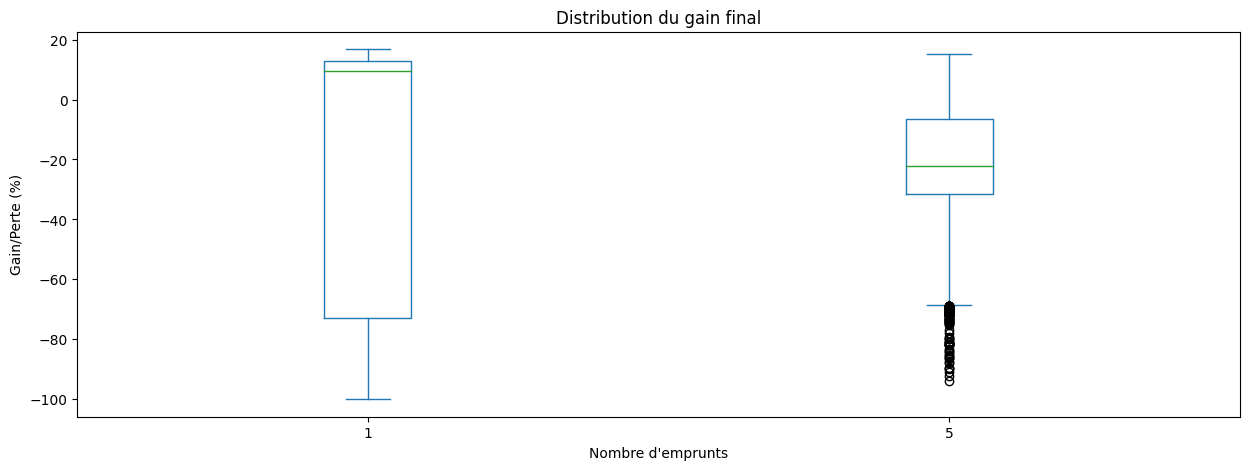

In [354]:
b2.final_liquidite.plot(kind='box', figsize=(15, 5), title="Distribution du gain final")
plt.xlabel("Nombre d'emprunts")
plt.ylabel("Gain/Perte (%)")
plt.show()

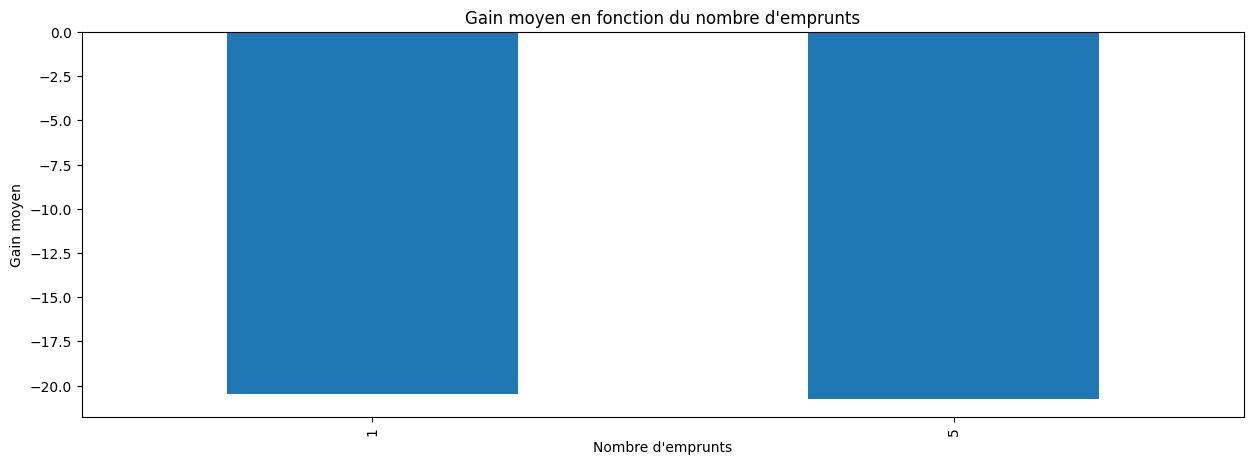

In [355]:
b2.final_liquidite.mean().plot(kind='bar', figsize=(15, 5), title="Gain moyen en fonction du nombre d'emprunts")
plt.title("Gain moyen en fonction du nombre d'emprunts")
plt.xlabel("Nombre d'emprunts")
plt.ylabel("Gain moyen")
plt.show()